# Likelihood Ratio Matching

In this Jupyter notebook we show how the Likelihood Ratio technique of cross-matching optical (or NIR) and radio sources is determined.

The likelihood ratio is defined as the ratio of the probability that a radio source and an optical counterpart are related, to the probability they are not given by:

\begin{equation}     
LR = \frac{q(m)f(r)}{n(m)}
\end{equation}

Where $q(m)$ is the expected magnitude distribution of the optical counterparts,  $f(r)$ is the radial probability distribution function of the offsets between the radio and optical poistions and $n(m)$ is the full magnitude distribution of all the optical objects detected.

Here we follow the papers of Smith et al. 2011 and McAlpine et al. 2012 to work out the Likelihood Ratio. In this example we wish to cross-match a sample of radio sources from the Sydney University Molonglo Sky Survey (SUMSS, Mauch et al. 2003) with $K_{s}$-band detected objects in the Near-Infrared VISTA Hemisphere Survey (VHS, McMahon et al. 2013).  

You will first have to download the radio and near-infrared datasets that are available here: 
www.linktofollow.com

The first thing to do is import the numpy, astropy, scipy and matplotlib libaries that we will need:


In [1]:
import numpy
import math
from astropy.io import fits
from astropy.coordinates import SkyCoord
from astropy import units as u
from astropy.coordinates import search_around_sky
import scipy.signal.signaltools
import scipy.stats
from matplotlib import rc
rc('font', **{'family':'serif','serif':['Palatino']})
rc('text', usetex=True)

import matplotlib.pyplot as plt
%matplotlib inline

We first set the maximum matching radius in arcseconds, the limit of the NIR survey in magnitudes and the full-width-half-maximum of the beam of SUMMS

In [2]:
rmax=30.0 #take (FWHM/5)*0.655*5 arcsec
magmax=19.0
fwhm=45.0 # fwhm of beam

Then we open the fits file containing the optical catalogue and remove stars. For the VHS catalogue, mergedclass $= 1$ indicates the objects are galaxies.
We also select our objects have magnitudes $K_{s} > 10$. 

In [3]:
#read in VHS catalogue
hdulist=fits.open('vhs60_90_positions.fits')
cat=hdulist[1].data
mags=cat.field('KSPETROMAG')#-cat.field('EXTINCTION_R')
##ids=cat.field('CATAID')
ids=numpy.arange(1,len(mags)+1,1)
ra=cat.field('RA')
dec=cat.field('DEC')
Merg=cat.field('MERGEDCLASS')

keep=numpy.where((Merg==1)&(mags<magmax)&(mags>10.)) #&(ra > 160)&(ra <200)&)

ids=ids[keep]
mags=mags[keep]
ra =cat.field('RA')[keep] 
dec =cat.field('DEC')[keep]

Time to calculate $n(m)$, the full magnitude distribution of the optical sample. We want to produce a histogram. Firstly we define some magnitude bins:

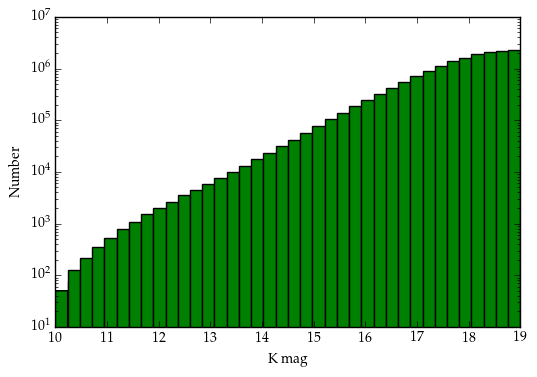

In [25]:
bins=numpy.linspace(10.,magmax,39) #change to match magnitude limits of sample 
plotbins=numpy.linspace(10.,magmax-0.1,38) # change to match magnitude limits of sample 

nm=plt.hist(mags,bins=bins,log=True)
cumnm=plt.hist(mags,bins=bins,cumulative=True)
plt.xlabel('K mag')
plt.ylabel('Number');

Now want to determine how many optical sources per sq arcsec, the survey area in this case is $273$ arsec. 

In [5]:
totalsources=cumnm[0][-1]
print ('Number of sources: '+'%.4f'% totalsources)
rarange=ra.max()-ra.min()
decrange=dec.max()-dec.min()

area =273.0 
print ('Area in deg sq: '+'%.2f' %area)
asecarea=area*3600.0*3600.0

print ('Area in arsec sq: '+'%.2f' %asecarea)
sdensity=totalsources/asecarea
sdensitycirc=sdensity*math.pi*rmax*rmax

print ('Number of optical sources per square arcsec: \t'+'%.5f'%sdensity)
print ('Number of optical sources per '+'%.2f'%rmax+'\" search radius:'+'\t' +'%.3f'%sdensitycirc)

Number of sources: 2250082.0000
Area in deg sq: 273.00
Area in arsec sq: 3538080000.00
Number of optical sources per square arcsec: 	0.00064
Number of optical sources per 30.00" search radius:	1.798


Now lets read in the radio source catalogue. We want to restrict our radio sources to those with a signal-to-noise ratio of $SNR \ge 5.0$ and in this case a peak flux of $s_{p} \ge 12$ mJy. We need to calculate the number of radio sources match this criteria

In [6]:
#read in radio source catalogue
radiofits=fits.open('sumss-45_-60.fits')
radio=radiofits[1].data

snr=radio.field('PEAKFLUX')/radio.field('PEAKFLUX_ERR')
snrkeep=numpy.where((snr>=5.0)&(radio.field('PEAKFLUX')>=12))

print ('Total Number of Radio sources: ' +numpy.str_(len(snr)))
print ('Radio sources match selection criteria: ' + numpy.str_(len(snrkeep[0])))

Total Number of Radio sources: 7913
Radio sources match selection criteria: 5377


A histogram of the SNR ratio can be seen below: 

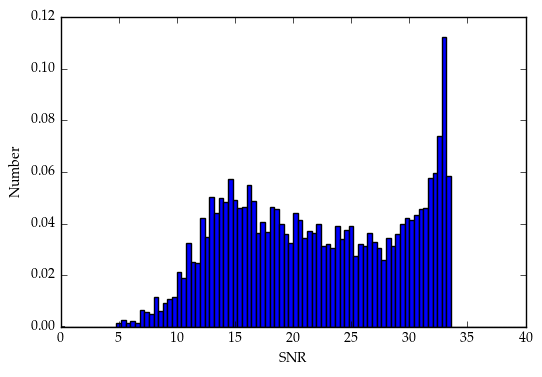

In [27]:
plt.figure(10)
plt.hist(snr[snrkeep], bins=100,range=(0,40),normed=True)
plt.xlabel('SNR')
plt.ylabel('Number');
#plt.savefig('Fig1.pdf')

Now lets calculate $q(m)$, the expected distribution of the true infrared counterparts as a function of $K_{s}$-band magnitude.  

$q(m)$ is determined here using the method of Ciliegi et al 2003. Firstly the magnitude distribution (${\rm total(m)}$) of all possible counterparts are within a fixes search radio $r_{max}$ is calculated. 
The background source count is subtracted from ${\rm total(m)}$ to obtain the magnitude distribution of excess sources detected around the radio positions known as ${\rm real(m)}$. This is given by:

\begin{equation}
{\rm real(m)} = {\rm total(m)} - (n(m)\,N_{radio} \times \pi\,r_{max}^{2})
\end{equation}  

$q_{m}$ is determined by normalising ${\rm real(m)}$ and scaling it by a factor $Q_{0}$. $Q_{0}$ is an estimate of the fraction of radio sources with infrared counterparts above the magnitude limit:

\begin{equation}
q(m) = \frac{\rm real(m)}{\Sigma \, \rm real(m)} \times Q_{0}
\end{equation} 

This $Q_{0}$ term is estimated by calculating the fraction of sources with radio sources above the background: 

\begin{equation}
Q_{0} = \frac{N_{matches} - (\Sigma \, n(m) \times \pi r^{2}_{max} \times N_{radio})}{N_{radio}}
\end{equation}.

Here $N_{matches}$ is the number of possible counterparts within $r_{max}$ of the radio positions. At large $r_{max}$ the expression leads to an overestimate of $Q_{0}$, because the radio-loud AGN tend to reside in dense enviroments, which results in an excess sources in the search radii, above the predicted background counts. One way to overcome this is by using the method of Fleuren et al. 2012 to estimate $Q_{0}$. This method will be covered in another notebook. In this example we use $Q_{0} = 0.395$.


Here we first find out how many optical counterparts are surrounding the radio sources, as we want to determine ${\rm total(m)}$:

In [8]:
radioid=numpy.arange(1,len(radio.field('PEAKFLUX'))+1,1)[snrkeep]
radiora=radio.field('RA')[snrkeep]
radiodec=radio.field('DEC')[snrkeep]
radioflux=radio.field('PEAKFLUX')[snrkeep]
radiofluxerr=radio.field('PEAKFLUX_ERR')[snrkeep]

radioc=SkyCoord(radiora,radiodec,unit='deg')
vhs=SkyCoord(ra,dec,unit='deg')

idxrad,idxmatch,d2d,d3d = search_around_sky(radioc,vhs,rmax*u.arcsec)

matchid=ids[idxmatch]
matchra=ra[idxmatch]
matchdec=dec[idxmatch]
matchmag=mags[idxmatch]
mradioid=radioid[idxrad]
mradiora=radiora[idxrad]
mradiodec=radiodec[idxrad]
mradioflux=radioflux[idxrad]
mradiofluxerr=radiofluxerr[idxrad]

nmatchra=numpy.array([])
nmatchdec=numpy.array([])

#### Why set no match to zero ---- MATT?
nomatch=0

print (numpy.str_(len(matchid)) + ' counterparts within the search radius')
nmatch=len(matchid)
ncentre=len(radioid)
numpy.savetxt('radioid',mradioid, fmt = '%.5i')

16095 counterparts within the search radius


 Now we can determine $n(m) \,N_{radio}\, \pi r_{max}^{2}$ and ${\rm real(m)}$:

('total', array([    0.,     3.,     2.,     5.,     3.,     5.,     4.,    10.,
          12.,    16.,    10.,    18.,    25.,    31.,    42.,    60.,
          66.,    80.,   107.,   167.,   171.,   233.,   275.,   368.,
         422.,   538.,   622.,   819.,   954.,  1137.,  1300.,  1545.,
        1667.,  1673.,  1471.,  1180.,   683.,   371.]))
('nmp', array([  2.14849711e-01,   3.26571561e-01,   3.86729480e-01,
         5.62906244e-01,   7.17598036e-01,   1.15589145e+00,
         1.30628624e+00,   1.79614359e+00,   2.27740694e+00,
         2.64265145e+00,   3.63096012e+00,   4.26261827e+00,
         5.92125804e+00,   7.72169862e+00,   1.00635605e+01,
         1.35613138e+01,   1.84813722e+01,   2.54210178e+01,
         3.47712773e+01,   4.66911393e+01,   6.44592104e+01,
         8.59613695e+01,   1.16207912e+02,   1.53669107e+02,
         2.01769661e+02,   2.63861227e+02,   3.38770728e+02,
         4.31856514e+02,   5.45357319e+02,   6.73094066e+02,
         8.15440594e+02,   9.56

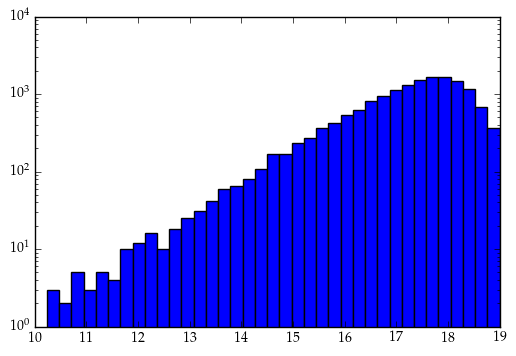

In [9]:
total= plt.hist(matchmag,bins=bins,log=True,cumulative=False)
print ('total', total[0])
nmp=(nm[0]/asecarea)*math.pi*numpy.power(rmax,2)*ncentre
print ('nmp', nmp)

real=total[0]-nmp
print ('real', real)

numpy.savetxt('realdist',real)
realtotal=numpy.cumsum(real)[-1]
print ('real total', realtotal)

qm=real/realtotal
print (qm)

We now calculate $q(m)$:

In [10]:
#q0=(nmatch-sdensity*pi*numpy.power(rmax,2)*ncentre)/ncentre
#from fleuren
q0 = 0.395

print (nmatch)
print (ncentre)
print (sdensity)

print ('Q0 = '+numpy.str_(q0))
qm1=qm*q0

nm1=(nm[0]/asecarea)
print (nm1)
#calculate qm/nm
qm_nm=numpy.divide(qm1,nm1)
print ('qm_nm', qm_nm)

# Why is qm_nm set to 500 here? - MATT

for i in range(0,21):
  qm_nm[i]=500#qm_nm[18] 
  
print (qm_nm)

16095
5377
0.00063596131235
Q0 = 0.395
[  1.41319586e-08   2.14805770e-08   2.54375254e-08   3.70257315e-08
   4.72007416e-08   7.60299371e-08   8.59223081e-08   1.18143174e-07
   1.49798761e-07   1.73823090e-07   2.38830100e-07   2.80378058e-07
   3.89476778e-07   5.07902591e-07   6.61940940e-07   8.92009225e-07
   1.21563108e-06   1.67209334e-06   2.28711618e-06   3.07115724e-06
   4.23987021e-06   5.65419663e-06   7.64369375e-06   1.01077421e-05
   1.32716049e-05   1.73557410e-05   2.22829896e-05   2.84058020e-05
   3.58714331e-05   4.42734477e-05   5.36364356e-05   6.28849546e-05
   6.99800457e-05   7.31880003e-05   6.91041469e-05   5.49569258e-05
   3.44669991e-05   1.66717542e-05]
('qm_nm', array([ -934.46069999,  7649.82046144,  3898.17165756,  7365.86205152,
        2972.15827168,  3107.70391134,  1926.96635382,  4268.1339433 ,
        3989.35340015,  4723.2552308 ,  1639.13049633,  3011.53951131,
        3010.9031623 ,  2817.08194819,  2965.48599333,  3199.92059449,
        24

Now back to $f(r)$. $f(r)$ is the radial probability distribution function of the positional errors as a function of the counterparts separation, $r$, from the radio sources given by:

\begin{equation}
f(r) = \frac{1}{2\pi\sigma_{pos}^{2}}\exp\Big(\frac{-r^{2}}{2\sigma_{pos}^{2}}\Big)
\end{equation}

Where $r$ is the separation between the radio and NIR positions and $\sigma_{pos}$ is the positional error. 
Here we use the equation of Ivison et al. 2007 to estimate the positional error for each radio source, which is given by:

\begin{equation}
\sigma_{fit} = 0.6 \times \frac{FWHM}{SNR}
\end{equation}

We add this in quadrature with an error of 1 arcsec. 

\begin{equation}
\sigma_{pos}^2 = 1 + \sigma_{fit}   
\end{equation}

In this code. We first need to create a function for a Gaussian:  

In [11]:
def gaus(r,sigma):
    y=0.5/(math.pi*numpy.power(sigma,2))*numpy.exp(-0.5*numpy.power(numpy.divide(r,sigma),2))
    rtest=numpy.linspace(0,100,2000)
    y1=numpy.multiply(rtest,y)
    norm=numpy.trapz(y1,x=rtest)
    fr=y/(2*math.pi*norm)
    return y

Now we can calculate the likelihood ratio for each source/counterpart pair. The calculation of $f(r)$ and LR is done in a loop:

In [12]:
LR=numpy.zeros([nmatch])
matchsep=numpy.power(numpy.power((matchra-mradiora)*3600.0,2)+numpy.power((matchdec-mradiodec)*3600.0,2),0.5)

msnr=numpy.divide(mradioflux,mradiofluxerr)

#calculate LR for each match pair
for i in range(0, nmatch):
    magbin=numpy.where(matchmag[i]<nm[1])
    qmsmi=qm_nm[magbin[0][0]-1]
    sigma0=max(numpy.power(numpy.power(1.0,2)+numpy.power(0.6*fwhm/msnr[i],2),0.5),0.5)
    fr=max(gaus(r=matchsep[i],sigma=sigma0),0.000001)
    LR[i]=qmsmi*fr
rel=numpy.zeros([nmatch])

/Users/Matt1/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:6: RuntimeWarning: invalid value encountered in double_scalars


Each radio source might have more than one counterpart. To account for this, we define a reliability $R_{j}$ for each object $j$ being the right counterpart, as done in Sutherland & Saunders (1992):

\begin{equation}
R_{j} = \frac{L_{j}}{\sum_{i} L_{i} + (1- Q_{0})}
\end{equation} 

We assume matches with a reliability $R > 0.8$, are robust matches. 

In [13]:
for i in range(0,nmatch):
    idmatch=numpy.where(mradioid[i]==mradioid)
    LRarray=LR[idmatch]
    LRsum=numpy.sum(LRarray)
    rel[i]=LR[i]/(LRsum+(1-q0))

reliable=numpy.where(rel>0.8)
xreliable=numpy.where(rel<0.8)
print ('Number of reliable sources '+ numpy.str_(len(reliable[0])))
minus=(1.0-rel[reliable])

Number of reliable sources 1178


We can also calculate the number of false identifications $N_{false}$ is given by:

\begin{equation}
N_{False} = {\rm \sum_{Rel >0.8} (1-Rel)}
\end{equation}

In [14]:
minus=(1.0-rel[reliable])
minusum=numpy.sum(minus)
print ('Number of False IDs')
print (minusum)

Number of False IDs
81.3645667877


Here we can save our output, first a list containing all the matches and their radio properties. 

In [15]:
filename="Likelihoodratio.csv"
file=open(filename,'w')
s='#No \t RA \t\t DEC \t radio_ra \t radio_dec \t mag \t S \t ErrS \t sep \t radioid \t idno \t LR \t rel \t snr \n'
file.write(s)
for i in range(0,nmatch):
    s=numpy.str_(i+1)+'\t'+'%.6f'%matchra[i]+'\t '+'%.6f'%matchdec[i]+'\t'+'%.6f'%mradiora[i]+'\t '+'%.6f'%mradiodec[i]+'\t'+'%4.6f'%matchmag[i]+'\t'+'%4.6f'%mradioflux[i]+'\t'+'%4.6f'%mradiofluxerr[i]+'\t'+'%.6f'%matchsep[i]+'\t'+'%i'%mradioid[i]+'\t'+'%i'%matchid[i]+'\t\t'+'%4.4f'%LR[i]+'\t'+'%.4f'%rel[i]+'\t'+'%.4f'%msnr[i]+ '\n'
    file.write(s)
file.close

<function close>

We can also save lists of all the reliable matches, non-reliable matches and non matches: 

In [16]:
file=open('reliable.reg','w')
for i in range(0,len(reliable[0])):
    s='fk5; circle('+'%.6f'%mradiora[reliable[0][i]]+','+'%.6f'%mradiodec[reliable[0][i]]+',2.8")# color=green'+'\n'
    file.write(s)
file.close    

file=open('nonreliable.reg','w')
for i in range(0,len(xreliable[0])):
    s='fk5; circle('+'%.6f'%mradiora[xreliable[0][i]]+','+'%.6f'%mradiodec[xreliable[0][i]]+',2.75")# color=magenta'+'\n'
    file.write(s)
file.close  

file=open('nomatch.reg','w')
for i in range(0,len(nmatchra)):
    s='fk5; circle('+'%.6f'%nmatchra[i]+','+'%.6f'%nmatchdec[i]+',2.8")# color=red'+'\n'
    file.write(s)
file.close

<function close>

We can also make some plots! The first plot shows the $K_{s}$-band magnitude distribution of all NIR sources which surround the radio sources within $r_{max} =30$ arcseconds, this is seen as $\rm total(m)$ (red histogram). The dashed histogram shows the $K_{s}$-band magnitude distibution of excess NIR sources surrounding the radio sources (${\rm real(m)}$). The expected background counts of NIR objects within the search radius can also be seen.     

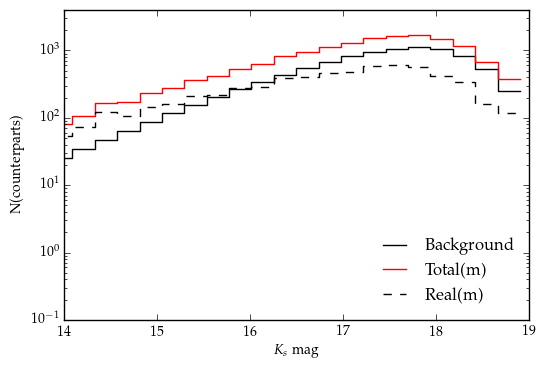

In [28]:
plt.figure(2)
plt.semilogy(plotbins,nmp,ls='steps-',color='k',label='Background')
plt.semilogy(plotbins,total[0],ls='steps-',color='r',label='Total(m)')
plt.semilogy(plotbins,real,ls='steps--',color='k',label='Real(m)')

leg=plt.legend(loc='lower right')
frame=leg.get_frame()
frame.set_edgecolor('1.0')
plt.ylim(ymin=0.1,ymax=4000)
plt.ylabel('N(counterparts)')
plt.xlabel('$K_{s}$ mag')
plt.xlim(xmin=14,xmax=19.0);

The ratio of ${q(m)}/{n(m)}$ represents the magnitude dependence on the LR. We fix q(m) at bright magnitudes. 

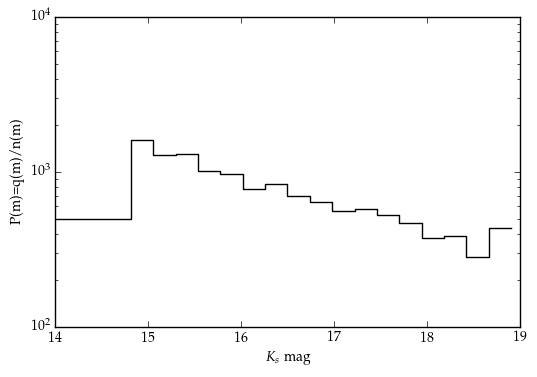

In [29]:
plt.figure(3)
plt.semilogy(plotbins,qm_nm,ls='steps-',color='k')
plt.ylabel('P(m)=q(m)/n(m)')
plt.xlabel('$K_{s}$ mag')
plt.xlim(xmin=14,xmax=19.0);

Here we plot the resulting q(m) distribution:

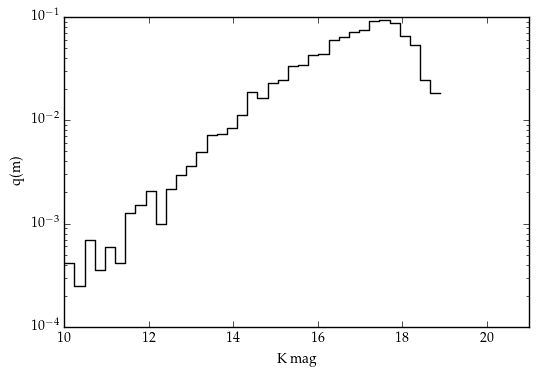

In [19]:
plt.figure(4)
plt.semilogy(plotbins,qm,ls='steps-',color='k',label='raw')
plt.xlim(xmin=10,xmax=21.0)
plt.xlabel('K mag')
plt.ylabel('q(m)')
plt.show()

This plot shows the distribution of the counterparts, and print the mean separation between radio source and counterparts in terms of RA and DEC. 

Mean RA
0.782362380652
0.000217322883514
4.79659336078e-05
Mean Dec
0.23677842736
6.57717853778e-05
2.93170330165e-05


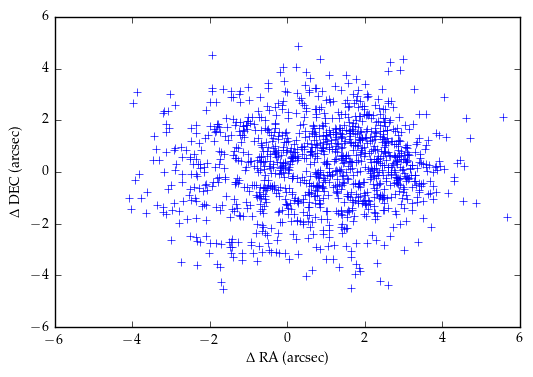

In [20]:
plt.figure(5)
plt.plot(3600.0*(matchra[reliable]-mradiora[reliable]),3600.0*(matchdec[reliable]-mradiodec[reliable]),'+')

plt.xlabel(r'$\Delta$ RA (arcsec)')
plt.ylabel(r'$\Delta$ DEC (arcsec)')
#plt.savefig('match_positions.pdf',orientation='portrait')

print ('Mean RA')
print (numpy.mean(3600.0*(matchra[reliable]-mradiora[reliable])))
print (numpy.mean(matchra[reliable]-mradiora[reliable]))
print (numpy.std(matchra-mradiora)/numpy.power(len(matchra),0.5))

print ('Mean Dec')
print (numpy.mean(3600.0*(matchdec-mradiodec)[reliable[0]]))
print (numpy.mean((matchdec-mradiodec)[reliable]))
print (numpy.std(matchdec-mradiodec)/numpy.power(len(matchdec),0.5))

Here we show the Reliability as a function of the likelihood ratio. As some radio sources have more than one counterpart it is not a linear relationship.   

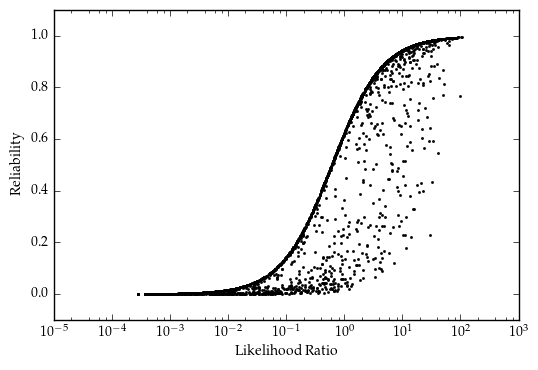

In [30]:
plt.figure(6)
plt.semilogx(LR,rel,'.',color='k',ms=3)
plt.xlim(xmin=0.00001,xmax=1000)
plt.ylim(ymin=-0.1,ymax=1.1)
plt.xlabel('Likelihood Ratio')
plt.ylabel('Reliability');

Here we make a histogram of the LR values for all the potential counterparts. 

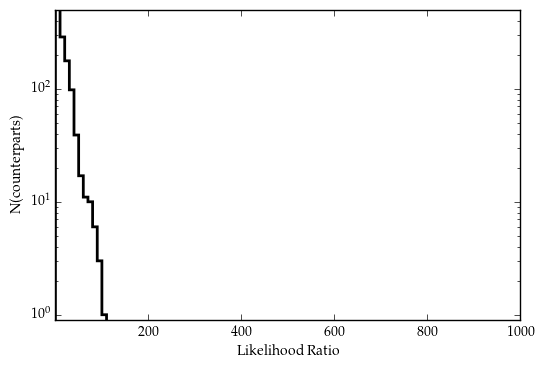

In [31]:
plt.figure(7)
plt.hist(LR,bins=(100),range=(1,1000),log=True,histtype='step',color='k',linewidth=2)
plt.plot(xscale='log')
plt.xlim(xmin=1.0,xmax=1000)
plt.ylim(ymin=0.9,ymax=500)
plt.xlabel('Likelihood Ratio')
plt.ylabel('N(counterparts)');

Here we plot a histogram of the reliability for each counterpart. 

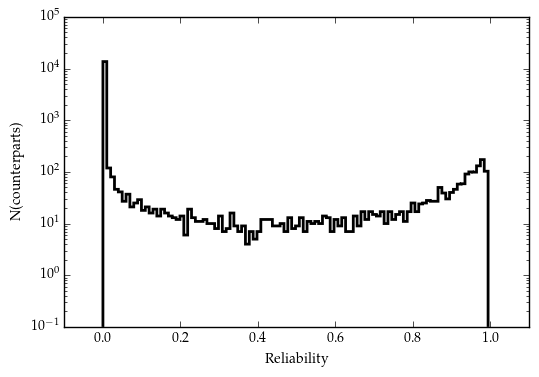

In [32]:
plt.figure(8)
plt.hist(rel,bins=100,log=True,histtype='step',color='k',linewidth=2)
plt.xlabel('Reliability')
plt.xlim(xmin=-0.1,xmax=1.1)
plt.ylabel('N(counterparts)');

Here we make histograms of $\Delta RA$ and $\Delta DEC$ of the reliable matches. 

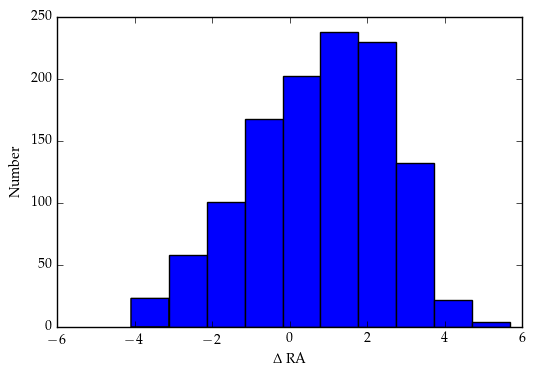

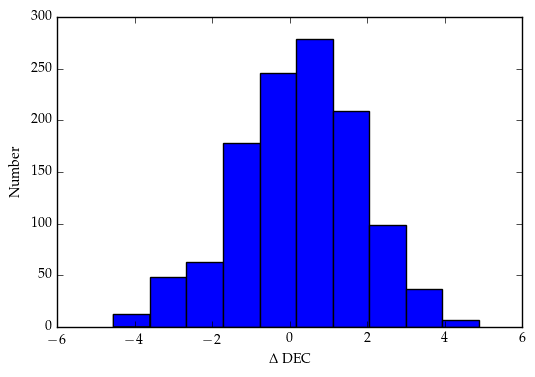

In [33]:
plt.figure(9)
plt.hist(3600.0*(matchra-mradiora)[reliable],bins=10)
plt.xlabel(r'$\Delta$ RA')
plt.ylabel('Number')
plt.figure(10)
plt.hist(3600.0*(matchdec-mradiodec)[reliable],bins=10)
plt.xlabel(r'$\Delta$ DEC')
plt.ylabel('Number')
plt.show;